In [ ]:
%%capture
!pip install rdkit-pypi
!pip install dgllife
!pip install --pre dgl-cu113 dglgo -f https://data.dgl.ai/wheels-test/repo.html

# Import Library

In [1]:
import dgl 
import sys
import torch
import random
import cv2
import torchvision
import statistics
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim

from numpy import array
from numpy import argmax
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import  History
from dgllife.utils import smiles_to_bigraph, CanonicalAtomFeaturizer, AttentiveFPAtomFeaturizer
from tqdm.notebook import tqdm, trange
from sklearn.model_selection import train_test_split

from utils.general import DATASET, get_dataset, separate_active_and_inactive_data, get_embedding_vector_class, count_lablel,data_generator, del_nan
from utils.general import count_lablel,data_generator, del_nan, up_and_down_Samplenig
from utils.gcn_pre_trained import get_muv_model, get_fingerprint
from model.heterogeneous_siamese_muv import siamese_model_attentiveFp_muv, siamese_model_Canonical_muv


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Data

In [2]:
cache_path='./muv_dglgraph.bin'

df = get_dataset("muv")

ids = df['mol_id'].tolist()
load_full = False

df = df.drop(columns=['mol_id'])

In [14]:
muv_tasks = df.columns.values[:17].tolist()

In [15]:
df

,MUV-466,MUV-548,MUV-600,MUV-644,MUV-652,MUV-689,MUV-692,MUV-712,MUV-713,MUV-733,MUV-737,MUV-810,MUV-832,MUV-846,MUV-852,MUV-858,MUV-859,smiles
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,Cc1cccc(N2CCN(C(=O)C34CC5CC(CC(C5)C3)C4)CC2)c1C
1,0.0,0.0,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,0.0,0.0,Cn1ccnc1SCC(=O)Nc1ccc(Oc2ccccc2)cc1
2,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,COc1cc2c(cc1NC(=O)CN1C(=O)NC3(CCc4ccccc43)C1=O...
3,NaN,0.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,O=C1/C(=C/NC2CCS(=O)(=O)C2)c2ccccc2C(=O)N1c1cc...
4,0.0,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NC(=O)NC(Cc1ccccc1)C(=O)O
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93082,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,O=C(NCc1ccccc1Cl)C1CCCO1
93083,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,COc1cc(NCCCCCN2C(=O)c3ccccc3C2=O)c2ncccc2c1
93084,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,CCN(CC)c1ccc(/C=C2/C(=O)ON=C2C)cc1
93085,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,Cc1cc(=O)oc2cc(OCC(=O)c3ccc4c(c3)NC(=O)CO4)ccc12


In [16]:
one = []
zero = []
nan = []
 
for task in muv_tasks:
    a = list(df[task].value_counts(dropna=False).to_dict().values())
    zero.append(a[0])
    nan.append(a[1])
    one.append(a[2])
    print(task ,"one:" ,a[2] ," zero:", a[0], " NAN:",a[1])


MUV-466 one: 27  zero: 78246  NAN: 14814
MUV-548 one: 29  zero: 78353  NAN: 14705
MUV-600 one: 30  zero: 78359  NAN: 14698
MUV-644 one: 30  zero: 78464  NAN: 14593
MUV-652 one: 29  zero: 78185  NAN: 14873
MUV-689 one: 29  zero: 78486  NAN: 14572
MUV-692 one: 30  zero: 78443  NAN: 14614
MUV-712 one: 28  zero: 78676  NAN: 14383
MUV-713 one: 29  zero: 78251  NAN: 14807
MUV-733 one: 28  zero: 78405  NAN: 14654
MUV-737 one: 29  zero: 78396  NAN: 14662
MUV-810 one: 29  zero: 78443  NAN: 14615
MUV-832 one: 30  zero: 78420  NAN: 14637
MUV-846 one: 30  zero: 78376  NAN: 14681
MUV-852 one: 29  zero: 78436  NAN: 14622
MUV-858 one: 29  zero: 78313  NAN: 14745
MUV-859 one: 24  zero: 78341  NAN: 14722


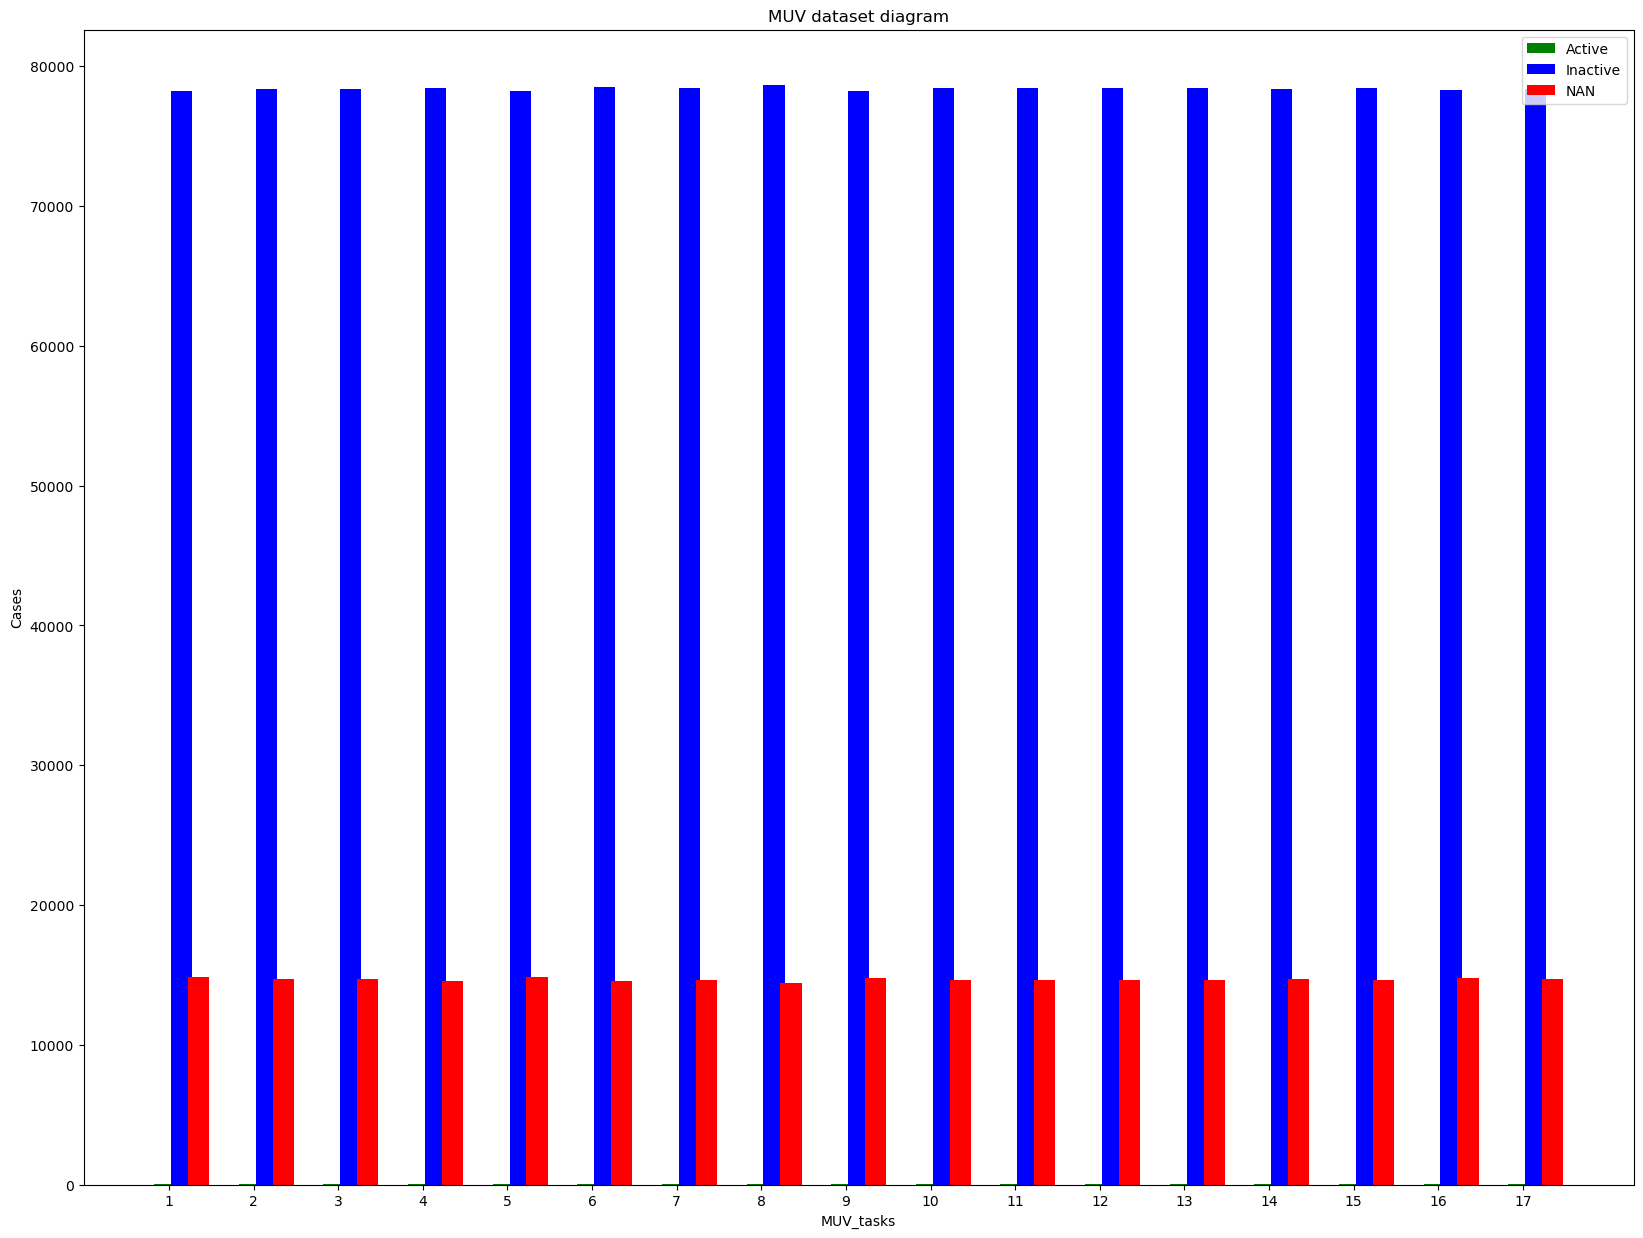

In [17]:
# Importing the matplotlib library
import numpy as np
import matplotlib.pyplot as plt
# Declaring the figure or the plot (y, x) or (width, height)
plt.figure(figsize=[20, 15])

X = np.arange(1,len(muv_tasks)+1)
plt.bar(X + 0.2, one, color = 'g', width = 0.25)
plt.bar(X + 0.4, zero, color = 'b', width = 0.25)
plt.bar(X + 0.6, nan, color = 'r', width = 0.25)

# Creating the legend of the bars in the plot
plt.legend(['Active' , 'Inactive' ,'NAN'])
# Overiding the x axis with the country names
plt.xticks([i + 0.25 for i in range(1,18)], X)
# Giving the tilte for the plot
plt.title("MUV dataset diagram")
# Namimg the x and y axis
plt.xlabel('MUV_tasks')
plt.ylabel('Cases')
# Saving the plot as a 'png'
plt.savefig('4BarPlot.png')
# Displaying the bar plot
plt.show()

# Required functions

In [18]:
from dgllife.model import MLPPredictor

def create_dataset_with_gcn(ds, class_embed_vector, GCN, tasks):

    created_data = []
    data = np.arange(len(tasks))
    onehot_encoded = to_categorical(data)
    for numberTask, dataset in enumerate(ds):
        for i, data in enumerate(dataset):
            smiles, g, label, mask = data
            g = g.to(device)
            g = dgl.add_self_loop(g)
            graph_feats = g.ndata.pop('h')
            embbed = GCN(g, graph_feats)
            embbed = embbed.to('cpu')
            embbed = embbed.detach().numpy()
            a = ( embbed, onehot_encoded[numberTask], class_embed_vector[numberTask], label, tasks[numberTask])
            created_data.append(a)
    print('Data created!!')
    return created_data 

# **Drug-based strategy with BioAct-Het**

## Classification with BioAct-Het and AttentiveFp GCN

In [3]:
model_name = 'GCN_attentivefp_MUV'
gcn_model = get_muv_model(model_name)
gcn_model.eval()
gcn_model = gcn_model.to(device)

Pretrained model loaded


C:\Users\Ali\anaconda3\envs\thesis\lib\site-packages\torch\cuda\__init__.py:132: UserWarning: 
    Found GPU0 NVIDIA GeForce GT 710 which is of cuda capability 3.5.
    PyTorch no longer supports this GPU because it is too old.
    The minimum cuda capability supported by this library is 3.7.
    
  warnings.warn(old_gpu_warn % (d, name, major, minor, min_arch // 10, min_arch % 10))


In [66]:
train, test = train_test_split(df,test_size=0.20, shuffle=True)

#Calculation of embedded vectors for each class
df_train_positive, df_train_negative = Separate_active_and_inactive_data(train, muv_tasks)
df_test_positive, df_test_negative = Separate_active_and_inactive_data(test, muv_tasks)

dataset_positive_train = [DATASET(d, smiles_to_bigraph, AttentiveFPAtomFeaturizer(), cache_file_path = cache_path) for d in df_train_positive]
dataset_negative_train = [DATASET(d, smiles_to_bigraph, AttentiveFPAtomFeaturizer(), cache_file_path = cache_path) for d in df_train_negative]   
dataset_positive_test = [DATASET(d, smiles_to_bigraph, AttentiveFPAtomFeaturizer(), cache_file_path = cache_path) for d in df_test_positive]
dataset_negative_test = [DATASET(d, smiles_to_bigraph, AttentiveFPAtomFeaturizer(), cache_file_path = cache_path) for d in df_test_negative]

print(len(dataset_positive_train) ,len(dataset_negative_train), len(dataset_positive_test), len(dataset_negative_test) )

embed_class_muv_train = get_embedding_vector_class(dataset_positive_train, dataset_negative_train, radius=2, size = 512)
embed_class_muv_test = get_embedding_vector_class(dataset_positive_test, dataset_negative_test, radius=2, size = 512)

#create_dataset       
train_notnan = del_nan (train, muv_tasks)
test_notnan = del_nan (test, muv_tasks)

train_dataset = [DATASET(d, smiles_to_bigraph, AttentiveFPAtomFeaturizer(), cache_file_path = cache_path) for d in train_notnan]
test_dataset = [DATASET(d, smiles_to_bigraph, AttentiveFPAtomFeaturizer(), cache_file_path = cache_path) for d in test_notnan]

train_ds = create_dataset_with_gcn(train_dataset, embed_class_muv_train, gcn_model, muv_tasks)
valid_ds = create_dataset_with_gcn(test_dataset, embed_class_muv_test, gcn_model, muv_tasks)

label_pos , label_neg, _ , _ = count_lablel(train_ds)
print(f'train positive label: {label_pos} - train negative label: {label_neg}')

train_ds = up_and_down_Samplenig(train_ds, scale_downsampling = 0.5)

label_pos , label_neg , _ , _ = count_lablel(train_ds)
print(f'up and down sampling => train positive label: {label_pos} - train negative label: {label_neg}')

label_pos , label_neg, _ , _ = count_lablel(valid_ds)
print(f'Test positive label: {label_pos} - Test negative label: {label_neg}')

Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing molecule 1000/11811
Processing molecule 2000/11811
Processing molecule 3000/11811
Processing molecule 4000/11811
Processing molecule 5000/11811
Processing molecule 6000/11811
Processing molecule 7000/11811
Processing molecule 8000/11811
Processing molecule 9000/11811
Processing molecule 10000/11811
Proce

Processing dgl graphs from scratch...
Processing molecule 1000/3038
Processing molecule 2000/3038
Processing molecule 3000/3038
Processing dgl graphs from scratch...
Processing molecule 1000/2839
Processing molecule 2000/2839
Processing dgl graphs from scratch...
Processing molecule 1000/2868
Processing molecule 2000/2868
Processing dgl graphs from scratch...
Processing molecule 1000/2875
Processing molecule 2000/2875
Processing dgl graphs from scratch...
Processing molecule 1000/2932
Processing molecule 2000/2932
Processing dgl graphs from scratch...
Processing molecule 1000/3000
Processing molecule 2000/3000
Processing molecule 3000/3000
Processing dgl graphs from scratch...
Processing molecule 1000/2932
Processing molecule 2000/2932
Processing dgl graphs from scratch...
Processing molecule 1000/2943
Processing molecule 2000/2943
Processing dgl graphs from scratch...
Processing molecule 1000/2988
Processing molecule 2000/2988
Processing dgl graphs from scratch...
Processing molecule 

Processing molecule 3000/3010
Processing dgl graphs from scratch...
Processing molecule 1000/2964
Processing molecule 2000/2964
Processing dgl graphs from scratch...
Processing molecule 1000/3042
Processing molecule 2000/3042
Processing molecule 3000/3042
Processing dgl graphs from scratch...
Processing molecule 1000/2846
Processing molecule 2000/2846
Processing dgl graphs from scratch...
Processing molecule 1000/2877
Processing molecule 2000/2877
Processing dgl graphs from scratch...
Processing molecule 1000/2880
Processing molecule 2000/2880
Processing dgl graphs from scratch...
Processing molecule 1000/2937
Processing molecule 2000/2937
Processing dgl graphs from scratch...
Processing molecule 1000/3004
Processing molecule 2000/3004
Processing molecule 3000/3004
Processing dgl graphs from scratch...
Processing molecule 1000/2937
Processing molecule 2000/2937
Processing dgl graphs from scratch...
Processing molecule 1000/2950
Processing molecule 2000/2950
Processing dgl graphs from s

In [67]:
# models = [siamese_net for task in sider_tasks_final]
Epoch_S = 15
l = []
r = []
lbls = []
for i , data in enumerate(train_ds):
    embbed_drug, onehot_task, embbed_task, lbl, task_name = data
    l.append(embbed_drug[0])
    r.append(embbed_task)
    lbls.append(lbl.tolist())

l = np.array(l).reshape(-1,128,1)
r = np.array(r).reshape(-1,512,1)
lbls=np.array(lbls)

history = History()

siamese_net = siamese_model_attentiveFp_muv()

s = siamese_net.fit([l, r], lbls, epochs = Epoch_S, shuffle=True, batch_size=128, callbacks=[history])

for j in range(1000):
    C=1
    Before = int(s.history['accuracy'][-1]*100)
    for i in range(2,Epoch_S+1):
        if  int(s.history['accuracy'][-i]*100)== Before:
            C=C+1
        else:
            C=1
        Before=int(s.history['accuracy'][-i]*100)
        print(Before)
    if C==Epoch_S:
        break
    s = siamese_net.fit([l, r], lbls, epochs = Epoch_S, shuffle=True, batch_size=128, callbacks=history)
print(j+1)

Epoch 1/15
2336/2336 [==============================] - 78s 33ms/step - loss: 0.6412 - accuracy: 0.6651 - mae: 0.4469 - mse: 0.2240 - auc_4: 0.5052
Epoch 2/15
2336/2336 [==============================] - 78s 33ms/step - loss: 0.6300 - accuracy: 0.6671 - mae: 0.4386 - mse: 0.2194 - auc_4: 0.5604
Epoch 3/15
2336/2336 [==============================] - 78s 33ms/step - loss: 0.6008 - accuracy: 0.6769 - mae: 0.4138 - mse: 0.2068 - auc_4: 0.6602
Epoch 4/15
2336/2336 [==============================] - 78s 33ms/step - loss: 0.5955 - accuracy: 0.6824 - mae: 0.4096 - mse: 0.2046 - auc_4: 0.6701
Epoch 5/15
2336/2336 [==============================] - 79s 34ms/step - loss: 0.5924 - accuracy: 0.6853 - mae: 0.4069 - mse: 0.2033 - auc_4: 0.6752
Epoch 6/15
2336/2336 [==============================] - 80s 34ms/step - loss: 0.5911 - accuracy: 0.6868 - mae: 0.4060 - mse: 0.2029 - auc_4: 0.6767
Epoch 7/15
2336/2336 [==============================] - 77s 33ms/step - loss: 0.5898 - accuracy: 0.6887 - mae: 0

In [63]:
result =[]   

l_valid = []
r_valid = []
lbls_valid = []

for i , data in enumerate(valid_ds):
            embbed_drug, onehot_task, embbed_task, lbl, task_name = data
            l_valid.append(embbed_drug[0])
            r_valid.append(embbed_task)
            lbls_valid.append(lbl.tolist())

l_valid = np.array(l_valid).reshape(-1,128,1)
r_valid = np.array(r_valid).reshape(-1,512,1)
lbls_valid = np.array(lbls_valid)


score  = siamese_net.evaluate([l_valid,r_valid],lbls_valid, verbose=1)
a = (score[1],score[4])
result.append(a)

1568/1568 [==============================] - 8s 5ms/step - loss: 0.3309 - accuracy: 0.9311 - mae: 0.2704 - mse: 0.0872 - auc_3: 0.7056


#### Dropout = 0.3 and downsampling = 0.5 

In [51]:
result

[(0.9605262875556946, 0.6688770055770874)]

In [55]:
result

[(0.9249719381332397, 0.6104376316070557)]

In [60]:
result

[(0.8861362934112549, 0.6251401901245117)]

In [64]:
result

[(0.9311238527297974, 0.7055920362472534)]

In [68]:
result

[(0.9311238527297974, 0.7055920362472534)]

## Classification with BioAct-Het and Canonical GCN 

In [26]:
model_GCN = 'GCN_attentivefp_MUV'
gcn_model = get_muv_model(model_GCN)
gcn_model.eval()
gcn_model = gcn_model.to(device)

Pretrained model loaded


In [26]:
from sklearn.model_selection import KFold

Epoch_S = 10

def evaluate_model(df, k = 10 , shuffle = False, tasks = tox21_tasks):
    result =[]    

    kf = KFold(n_splits=10, shuffle= shuffle, random_state=None)
    
    for train_index, test_index in kf.split(df):

        train = df.iloc[train_index]
        test =  df.iloc[test_index]
        
        #Calculation of embedded vectors for each class
        df_train_positive, df_train_negative = Separate_active_and_inactive_data(train, tasks)
        df_test_positive, df_test_negative = Separate_active_and_inactive_data(test, tasks)
        
        dataset_positive_train = [DATASET(d, smiles_to_bigraph, AttentiveFPAtomFeaturizer(), cache_file_path = cache_path) for d in df_train_positive]
        dataset_negative_train = [DATASET(d, smiles_to_bigraph, AttentiveFPAtomFeaturizer(), cache_file_path = cache_path) for d in df_train_negative]   
        dataset_positive_test = [DATASET(d, smiles_to_bigraph, AttentiveFPAtomFeaturizer(), cache_file_path = cache_path) for d in df_test_positive]
        dataset_negative_test = [DATASET(d, smiles_to_bigraph, AttentiveFPAtomFeaturizer(), cache_file_path = cache_path) for d in df_test_negative]
        
        embed_class_muv_train = get_embedding_vector_class(dataset_positive_train, dataset_negative_train, radius=2, size = 512)
        embed_class_muv_test = get_embedding_vector_class(dataset_positive_test, dataset_negative_test, radius=2, size = 512)
       
        #create_dataset       
        train_notnan = del_nan (train, tasks)
        test_notnan = del_nan (test, tasks)

        train_dataset = [DATASET(d, smiles_to_bigraph, CanonicalAtomFeaturizer(), cache_file_path = cache_path) for d in train_notnan]
        test_dataset = [DATASET(d, smiles_to_bigraph, CanonicalAtomFeaturizer(), cache_file_path = cache_path) for d in test_notnan]
          
        train_ds = create_dataset_with_gcn(train_dataset, embed_class_muv_train, gcn_model, tasks)
        valid_ds = create_dataset_with_gcn(test_dataset, embed_class_muv_test, gcn_model, tasks)
        
        label_pos , label_neg, _ , _ = count_lablel(train_ds)
        print(f'train positive label: {label_pos} - train negative label: {label_neg}')
        
        train_ds = up_and_down_Samplenig(train_ds, scale_downsampling = 0.5)
        
        label_pos , label_neg , _ , _ = count_lablel(train_ds)
        print(f'up and down sampling => train positive label: {label_pos} - train negative label: {label_neg}')

        label_pos , label_neg, _ , _ = count_lablel(valid_ds)
        print(f'Test positive label: {label_pos} - Test negative label: {label_neg}')

        l_train = []
        r_train = []
        lbls_train = []
        
        l_valid = []
        r_valid = []
        lbls_valid = []

        for i , data in enumerate(train_ds):
            embbed_drug, onehot_task, embbed_task, lbl, task_name = data
            l_train.append(embbed_drug[0])
            r_train.append(embbed_task)
            lbls_train.append(lbl.tolist())
        
        for i , data in enumerate(valid_ds):
            embbed_drug, onehot_task, embbed_task, lbl, task_name = data
            l_valid.append(embbed_drug[0])
            r_valid.append(embbed_task)
            lbls_valid.append(lbl.tolist())

        l_train = np.array(l_train).reshape(-1,128,1)
        r_train = np.array(r_train).reshape(-1,512,1)
        lbls_train = np.array(lbls_train)

        l_valid = np.array(l_valid).reshape(-1,128,1)
        r_valid = np.array(r_valid).reshape(-1,512,1)
        lbls_valid = np.array(lbls_valid)

        # create neural network model
        siamese_net = siamese_model_Canonical_muv()
        history = History()
        P = siamese_net.fit([l_train, r_train], lbls_train, epochs = Epoch_S, batch_size = 128, callbacks=[history])

        for j in range(100):
            C=1
            Before = int(P.history['accuracy'][-1]*100)
            for i in range(2,Epoch_S+1):
                if  int(P.history['accuracy'][-i]*100)== Before:
                    C=C+1
                else:
                    C=1
                Before=int(P.history['accuracy'][-i]*100)
                print(Before)
            if C==Epoch_S:
                break
            P = siamese_net.fit([l_train, r_train], lbls_train, epochs = Epoch_S, batch_size = 128, callbacks=[history])
        print(j+1)
        
        score  = siamese_net.evaluate([l_valid,r_valid],lbls_valid, verbose=1)
        a = (score[1],score[4])
        result.append(a)
    
    return result
 
 
scores = evaluate_model(df, 10, False, tox21_tasks)

Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing molecule 1000/6241
Processing molecule 2000/6241
Processing molecule 3000/6241
Processing molecule 4000/6241
Processing molecule 5000/6241
Processing molecule 6000/6241
Processing dgl graphs from scratch...
Processing molecule 1000/5859
Processing molecule 2000/5859
Processing molecule 3000/5859
Processing molecule 4000/5859
Processing molecule 5000/5859
Processing dgl graphs from scratch...
Processing molecule 1000/5202
Processing molecule 2000/5202
Processing molecule 3000/5202
Processing

499/499 [==============================] - 3s 6ms/step - loss: 0.4073 - accuracy: 0.8182 - mae: 0.2598 - mse: 0.1298 - auc_17: 0.8939
Epoch 7/10
499/499 [==============================] - 3s 6ms/step - loss: 0.4054 - accuracy: 0.8183 - mae: 0.2591 - mse: 0.1291 - auc_17: 0.8949
Epoch 8/10
499/499 [==============================] - 3s 6ms/step - loss: 0.4118 - accuracy: 0.8147 - mae: 0.2627 - mse: 0.1315 - auc_17: 0.8913
Epoch 9/10
499/499 [==============================] - 3s 6ms/step - loss: 0.4154 - accuracy: 0.8123 - mae: 0.2659 - mse: 0.1328 - auc_17: 0.8896
Epoch 10/10
499/499 [==============================] - 3s 6ms/step - loss: 0.4136 - accuracy: 0.8128 - mae: 0.2652 - mse: 0.1323 - auc_17: 0.8902
81
81
81
81
82
81
82
82
82
Epoch 1/10
499/499 [==============================] - 3s 6ms/step - loss: 0.4111 - accuracy: 0.8152 - mae: 0.2633 - mse: 0.1313 - auc_17: 0.8916
Epoch 2/10
499/499 [==============================] - 3s 6ms/step - loss: 0.4183 - accuracy: 0.8108 - mae: 0.2676

Processing molecule 4000/5254
Processing molecule 5000/5254
Processing dgl graphs from scratch...
Processing molecule 1000/5571
Processing molecule 2000/5571
Processing molecule 3000/5571
Processing molecule 4000/5571
Processing molecule 5000/5571
Processing dgl graphs from scratch...
Processing molecule 1000/6271
Processing molecule 2000/6271
Processing molecule 3000/6271
Processing molecule 4000/6271
Processing molecule 5000/6271
Processing molecule 6000/6271
Processing dgl graphs from scratch...
Processing molecule 1000/5804
Processing molecule 2000/5804
Processing molecule 3000/5804
Processing molecule 4000/5804
Processing molecule 5000/5804
Processing dgl graphs from scratch...
Processing molecule 1000/5258
Processing molecule 2000/5258
Processing molecule 3000/5258
Processing molecule 4000/5258
Processing molecule 5000/5258
Processing dgl graphs from scratch...
Processing molecule 1000/6368
Processing molecule 2000/6368
Processing molecule 3000/6368
Processing molecule 4000/6368


Processing molecule 2000/4851
Processing molecule 3000/4851
Processing molecule 4000/4851
Processing dgl graphs from scratch...
Processing molecule 1000/5937
Processing molecule 2000/5937
Processing molecule 3000/5937
Processing molecule 4000/5937
Processing molecule 5000/5937
Processing dgl graphs from scratch...
Processing molecule 1000/5648
Processing molecule 2000/5648
Processing molecule 3000/5648
Processing molecule 4000/5648
Processing molecule 5000/5648
Processing dgl graphs from scratch...
Processing molecule 1000/4396
Processing molecule 2000/4396
Processing molecule 3000/4396
Processing molecule 4000/4396
Processing dgl graphs from scratch...
Processing molecule 1000/6133
Processing molecule 2000/6133
Processing molecule 3000/6133
Processing molecule 4000/6133
Processing molecule 5000/6133
Processing molecule 6000/6133
Processing dgl graphs from scratch...
Processing molecule 1000/5483
Processing molecule 2000/5483
Processing molecule 3000/5483
Processing molecule 4000/5483


Processing molecule 6000/6261
Processing dgl graphs from scratch...
Processing molecule 1000/5807
Processing molecule 2000/5807
Processing molecule 3000/5807
Processing molecule 4000/5807
Processing molecule 5000/5807
Processing dgl graphs from scratch...
Processing molecule 1000/5241
Processing molecule 2000/5241
Processing molecule 3000/5241
Processing molecule 4000/5241
Processing molecule 5000/5241
Processing dgl graphs from scratch...
Processing molecule 1000/6369
Processing molecule 2000/6369
Processing molecule 3000/6369
Processing molecule 4000/6369
Processing molecule 5000/6369
Processing molecule 6000/6369
Processing dgl graphs from scratch...
Processing molecule 1000/5813
Processing molecule 2000/5813
Processing molecule 3000/5813
Processing molecule 4000/5813
Processing molecule 5000/5813
Processing dgl graphs from scratch...
Processing molecule 1000/5231
Processing molecule 2000/5231
Processing molecule 3000/5231
Processing molecule 4000/5231
Processing molecule 5000/5231


Processing molecule 5000/5627
Processing dgl graphs from scratch...
Processing molecule 1000/4409
Processing molecule 2000/4409
Processing molecule 3000/4409
Processing molecule 4000/4409
Processing dgl graphs from scratch...
Processing molecule 1000/6113
Processing molecule 2000/6113
Processing molecule 3000/6113
Processing molecule 4000/6113
Processing molecule 5000/6113
Processing molecule 6000/6113
Processing dgl graphs from scratch...
Processing molecule 1000/5500
Processing molecule 2000/5500
Processing molecule 3000/5500
Processing molecule 4000/5500
Processing molecule 5000/5500
Processing dgl graphs from scratch...
Processing molecule 1000/4413
Processing molecule 2000/4413
Processing molecule 3000/4413
Processing molecule 4000/4413
Processing dgl graphs from scratch...
Processing molecule 1000/5709
Processing molecule 2000/5709
Processing molecule 3000/5709
Processing molecule 4000/5709
Processing molecule 5000/5709
Processing dgl graphs from scratch...
Processing dgl graphs 

500/500 [==============================] - 8s 15ms/step - loss: 0.4217 - accuracy: 0.8092 - mae: 0.2701 - mse: 0.1349 - auc_21: 0.8854
Epoch 8/10
500/500 [==============================] - 8s 15ms/step - loss: 0.4166 - accuracy: 0.8115 - mae: 0.2668 - mse: 0.1332 - auc_21: 0.8879
Epoch 9/10
500/500 [==============================] - 8s 15ms/step - loss: 0.4180 - accuracy: 0.8109 - mae: 0.2684 - mse: 0.1340 - auc_21: 0.8867
Epoch 10/10
500/500 [==============================] - 8s 15ms/step - loss: 0.4164 - accuracy: 0.8124 - mae: 0.2666 - mse: 0.1332 - auc_21: 0.8880
81
81
80
81
80
81
81
81
81
Epoch 1/10
500/500 [==============================] - 9s 19ms/step - loss: 0.4156 - accuracy: 0.8129 - mae: 0.2664 - mse: 0.1329 - auc_21: 0.8882
Epoch 2/10
500/500 [==============================] - 9s 19ms/step - loss: 0.4146 - accuracy: 0.8122 - mae: 0.2656 - mse: 0.1325 - auc_21: 0.8890
Epoch 3/10
500/500 [==============================] - 9s 19ms/step - loss: 0.4145 - accuracy: 0.8130 - mae:

Processing molecule 2000/5560
Processing molecule 3000/5560
Processing molecule 4000/5560
Processing molecule 5000/5560
Processing dgl graphs from scratch...
Processing molecule 1000/6247
Processing molecule 2000/6247
Processing molecule 3000/6247
Processing molecule 4000/6247
Processing molecule 5000/6247
Processing molecule 6000/6247
Processing dgl graphs from scratch...
Processing molecule 1000/5793
Processing molecule 2000/5793
Processing molecule 3000/5793
Processing molecule 4000/5793
Processing molecule 5000/5793
Processing dgl graphs from scratch...
Processing molecule 1000/5238
Processing molecule 2000/5238
Processing molecule 3000/5238
Processing molecule 4000/5238
Processing molecule 5000/5238
Processing dgl graphs from scratch...
Processing molecule 1000/6353
Processing molecule 2000/6353
Processing molecule 3000/6353
Processing molecule 4000/6353
Processing molecule 5000/6353
Processing molecule 6000/6353
Processing dgl graphs from scratch...
Processing molecule 1000/5814


up and down sampling => train positive label: 31872 - train negative label: 32556
Test positive label: 550 - Test negative label: 6971
Epoch 1/10
504/504 [==============================] - 8s 15ms/step - loss: 0.5669 - accuracy: 0.7172 - mae: 0.3826 - mse: 0.1904 - auc_23: 0.7853
Epoch 2/10
504/504 [==============================] - 7s 15ms/step - loss: 0.5151 - accuracy: 0.7576 - mae: 0.3413 - mse: 0.1690 - auc_23: 0.8290
Epoch 3/10
504/504 [==============================] - 7s 15ms/step - loss: 0.5004 - accuracy: 0.7654 - mae: 0.3304 - mse: 0.1634 - auc_23: 0.8392
Epoch 4/10
504/504 [==============================] - 7s 15ms/step - loss: 0.4889 - accuracy: 0.7719 - mae: 0.3213 - mse: 0.1590 - auc_23: 0.8472
Epoch 5/10
504/504 [==============================] - 7s 15ms/step - loss: 0.4783 - accuracy: 0.7796 - mae: 0.3128 - mse: 0.1550 - auc_23: 0.8541
Epoch 6/10
504/504 [==============================] - 7s 15ms/step - loss: 0.4727 - accuracy: 0.7819 - mae: 0.3094 - mse: 0.1531 - auc_

Processing molecule 1000/6276
Processing molecule 2000/6276
Processing molecule 3000/6276
Processing molecule 4000/6276
Processing molecule 5000/6276
Processing molecule 6000/6276
Processing dgl graphs from scratch...
Processing molecule 1000/5888
Processing molecule 2000/5888
Processing molecule 3000/5888
Processing molecule 4000/5888
Processing molecule 5000/5888
Processing dgl graphs from scratch...
Processing molecule 1000/5204
Processing molecule 2000/5204
Processing molecule 3000/5204
Processing molecule 4000/5204
Processing molecule 5000/5204
Processing dgl graphs from scratch...
Processing molecule 1000/4986
Processing molecule 2000/4986
Processing molecule 3000/4986
Processing molecule 4000/4986
Processing dgl graphs from scratch...
Processing molecule 1000/4893
Processing molecule 2000/4893
Processing molecule 3000/4893
Processing molecule 4000/4893
Processing dgl graphs from scratch...
Processing molecule 1000/5972
Processing molecule 2000/5972
Processing molecule 3000/5972


Processing molecule 4000/5813
Processing molecule 5000/5813
Processing dgl graphs from scratch...
Processing molecule 1000/5224
Processing molecule 2000/5224
Processing molecule 3000/5224
Processing molecule 4000/5224
Processing molecule 5000/5224
Processing dgl graphs from scratch...
Processing molecule 1000/6093
Processing molecule 2000/6093
Processing molecule 3000/6093
Processing molecule 4000/6093
Processing molecule 5000/6093
Processing molecule 6000/6093
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Data created!!
Data created!!
train positive label: 5309 - train negative labe

Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
class vector created!!
class vector created!!
Processing dgl graphs from scratch...
Processing molecule 1000/6531
Processing molecule 2000/6531
Processing molecule 3000/6531
Processing molecule 4000/6531
Processing molecule 5000/6531
Processing molecule 6000/6531
Processing dgl graphs from scratch...
Processing molecule 1000/6072
Processing molecule 2000/6072
Processing molecule 3000/6072
Processing molecule 4000/6072
Processing molecule 5000/6072
Processing molecule 6000/6072
Processing dgl graphs from scratch...
Processing molecule 1000/5901
Processing molecule 2000/5901
Pr

#### Dropout = 0.3 and downsampling = 0.5 

In [27]:
scores

[(0.8368595242500305, 0.7961744070053101),
 (0.8724093437194824, 0.7901719808578491),
 (0.891804575920105, 0.8238518834114075),
 (0.8417275547981262, 0.8028419017791748),
 (0.9066919088363647, 0.7792837619781494),
 (0.8721559047698975, 0.7883057594299316),
 (0.8473607301712036, 0.7736819386482239),
 (0.8497915863990784, 0.7874884605407715),
 (0.892120897769928, 0.7536473274230957),
 (0.8450775742530823, 0.7922624349594116)]

In [28]:
acc = []
auc = []
for i in scores:
    acc.append(i[0])
    auc.append(i[1])

print(f'accuracy= {np.mean(acc)} AUC= {np.mean(auc)} STD_AUC= {np.std(auc)}')

accuracy= 0.8655999600887299 AUC= 0.7887709856033325 STD_AUC= 0.017466662954986615
